In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [14]:
from pathlib import Path
IMG_FACTOR = 12
SIZE = int(0.8 * (48 + IMG_FACTOR * 16))

EXP_DIR = Path('../../experiments/')
DATA_DIR = Path(f'../../data/berea_{SIZE}/')
berea_mink = pd.read_csv(DATA_DIR / 'minkowski.csv')

In [15]:
from scipy.stats import norm

def plot_minkowski_distribution(exp_dir):
    seed_stats = pd.read_csv(exp_dir / f'seeds_analyze_{SIZE}.csv')
    titles = ['$V$', '$B$', '$S$', '$\\xi$']
    for i, metric in enumerate(['V', 'S', 'B', 'Xi']):
        data = seed_stats[metric]
        fig = plt.figure(figsize=(10, 8))
        ax = fig.gca()
        sns.distplot(
            data,
            kde=False,
            color='b',
            label='реконструкции',
            ax=ax,
#             bins=5,
            fit=norm,
            fit_kws={'color': 'blue', 'alpha': 0.4}
        )
        sns.distplot(
            berea_mink[metric],
            kde=False,
            color='r',
            label=f'образцы ${SIZE}^3$',
            ax=ax,
#             bins=20,
            fit=norm,
            fit_kws={'color': 'red', 'alpha': 0.4}
        )

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        
        ax.set_xlabel(titles[i], fontsize=18) 
        ax.set_ylabel('$p_{\\cal{N}}(x)$', fontsize=18) 
        ax.legend(fontsize=16)
        plt.title(f"Распределение функционала Минковского {titles[i]}", fontsize=20)
        plt.show()
        plt.close(fig)

In [16]:
from utils import two_point_correlation


def correlation_function(cov):
    p = cov[0]
    return (cov-p**2)/(p-p**2)


def plot_correlation_pph(exp_dir, dataset_dir):
    orig_files = list((dataset_dir / 'covariance_stats').glob('*.csv'))
    orig_pphs = []
    for file in orig_files:
        cov_pph = pd.read_csv(file)
        orig_pphs.append(cov_pph.values.T)
    orig_pphs = np.array(orig_pphs)
    
    orig_avg_pph = np.mean(orig_pphs.reshape(-1, orig_pphs.shape[-1]), axis=0)
    orig_std_pph = np.std(orig_pphs.reshape(-1, orig_pphs.shape[-1]), axis=0)
    
    orig_avg_corr = np.mean([correlation_function(cov) for cov in orig_pphs.reshape(-1, orig_pphs.shape[-1])], axis=0)
    orig_std_corr = np.std([correlation_function(cov) for cov in orig_pphs.reshape(-1, orig_pphs.shape[-1])], axis=0)

    seeds_pphs = []
    seed_files = list((exp_dir / f'covariance_stats_{SIZE}').glob('*.csv'))
    for file in seed_files:
        cov_pph = pd.read_csv(file)
        seeds_pphs.append(cov_pph.values.T)
    seeds_pphs = np.array(seeds_pphs)
    
    radial_avg_pph = np.mean(seeds_pphs.reshape(-1, seeds_pphs.shape[-1]), axis=0)
    radial_std_pph = np.std(seeds_pphs.reshape(-1, seeds_pphs.shape[-1]), axis=0)
    
    radial_avg_corr = np.mean([correlation_function(cov) for cov in seeds_pphs.reshape(-1, seeds_pphs.shape[-1])], axis=0)
    radial_std_corr = np.std([correlation_function(cov) for cov in seeds_pphs.reshape(-1, seeds_pphs.shape[-1])], axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.errorbar(
        range(len(radial_avg_pph)),
        radial_avg_pph,
        yerr=radial_std_pph,
        c="black",
        elinewidth=2,
        fmt='-',
        label="реконструкции",
        linewidth=2
    )
    ax.errorbar(
        range(len(orig_avg_pph)),
        orig_avg_pph,
        yerr=orig_std_pph,
        linestyle="--",
        linewidth=1,
        c="red",
        label=f"образцы ${SIZE}^3$"
    )
    ax.axvline(64, color="blue", linestyle="-.", linewidth=3)
    ax.text(64+2., 0.16, 'Размер образцов при обучении', rotation=90, fontsize=18)
    ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    ax.set_xlabel("$r$, воксели", fontsize=18) 
    ax.set_ylabel("$S_2(r)$", fontsize=18)   
    ax.set_xlim(-1, SIZE+30)
    ax.set_ylim(0.0, 0.225)
    ax.grid()  
    ax.legend(fontsize=16) 
    plt.title("Радиальная двухточечная функция вероятности", fontsize=20)
    plt.show()
    plt.close(fig)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.errorbar(
        range(len(radial_avg_corr)),
        radial_avg_corr,
        yerr=radial_std_corr,
        c="black",
        elinewidth=2,
        fmt='-',
        label="реконструкции",
        linewidth=2
    )
    ax.errorbar(
        range(len(orig_avg_corr)),
        orig_avg_corr,
        yerr=orig_std_corr,
        linestyle="--",
        linewidth=1,
        c="red",
        label=f"образцы ${SIZE}^3$"
    )
    ax.axvline(64, color="blue", linestyle="-.", linewidth=3)
    ax.text(64+2., 0.75, 'Размер образцов при обучении', rotation=90, fontsize=18)
    ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    ax.set_xlabel("$r$, воксели", fontsize=18) 
    ax.set_ylabel(r"Функция корреляции", fontsize=18)
    ax.set_xlim(-1, SIZE+30)
    ax.set_ylim(-0.2, 1.0)
    ax.grid()  
    ax.legend(fontsize=16)
    plt.title("Функция корреляции", fontsize=20)
    plt.show()
    plt.close(fig)

## Experiment 2019-04-29 14:19

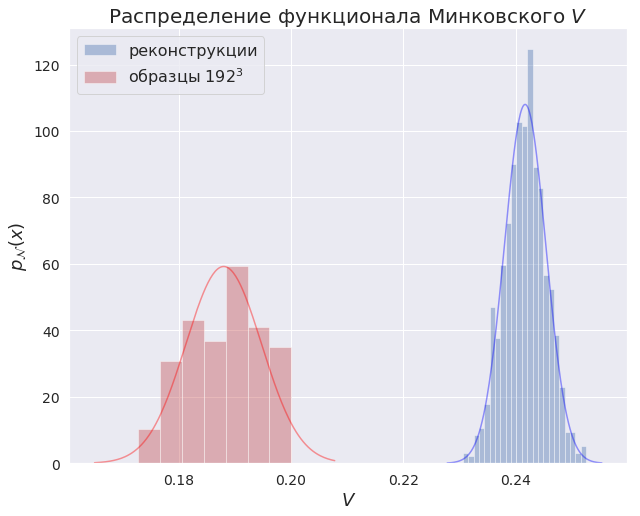

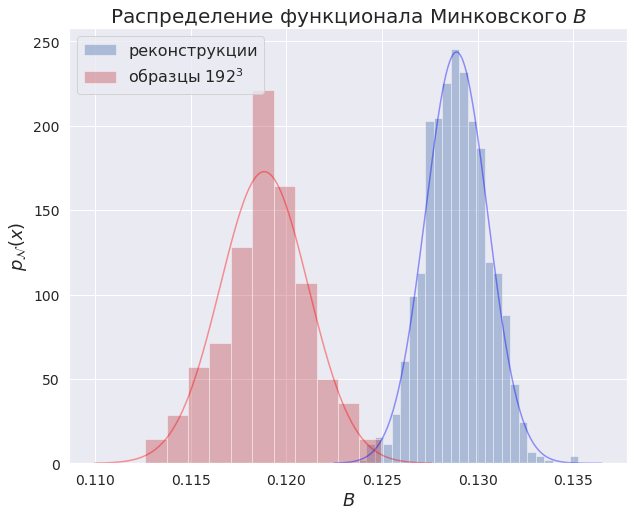

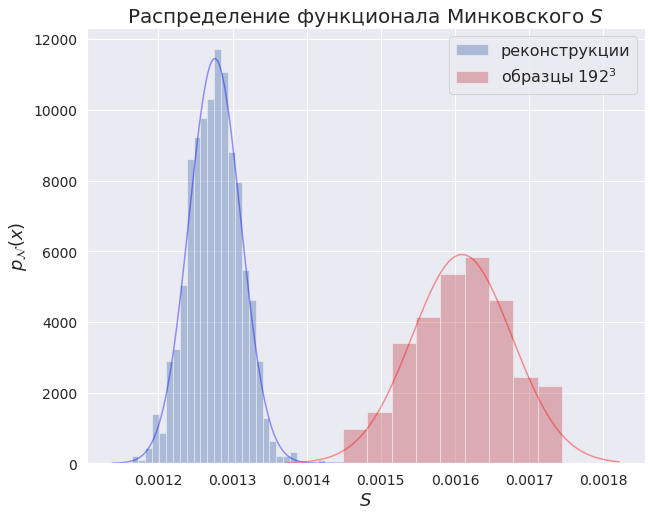

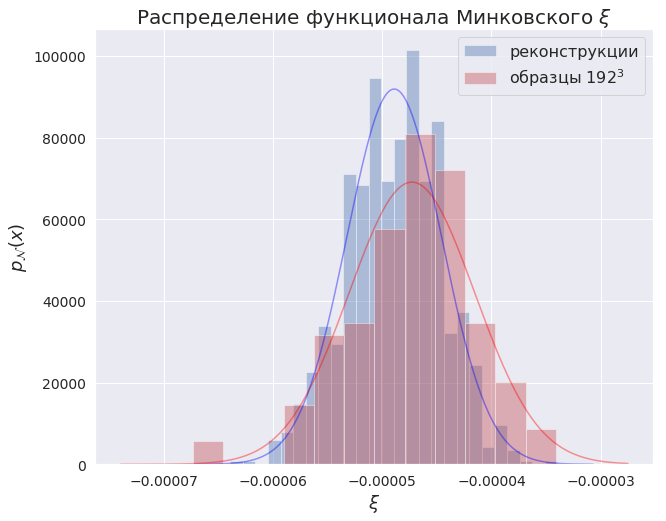

In [17]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-04-29_14_19'))

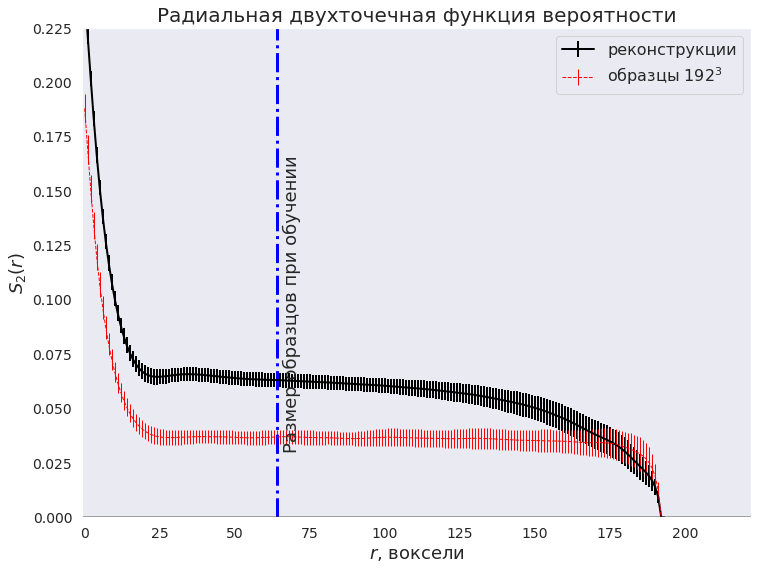

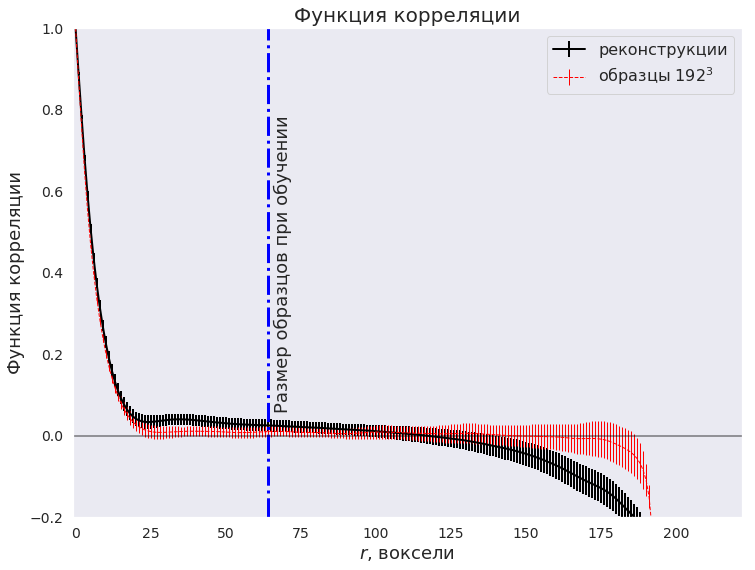

In [18]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-04-29_14_19'), dataset_dir=DATA_DIR)

## Original BEREA-pretrained

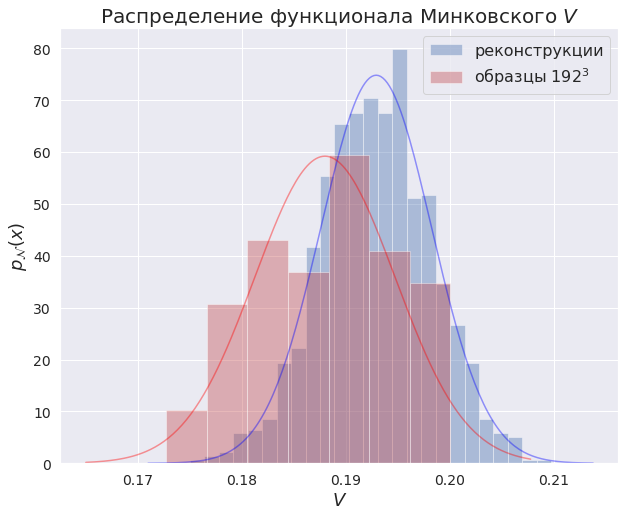

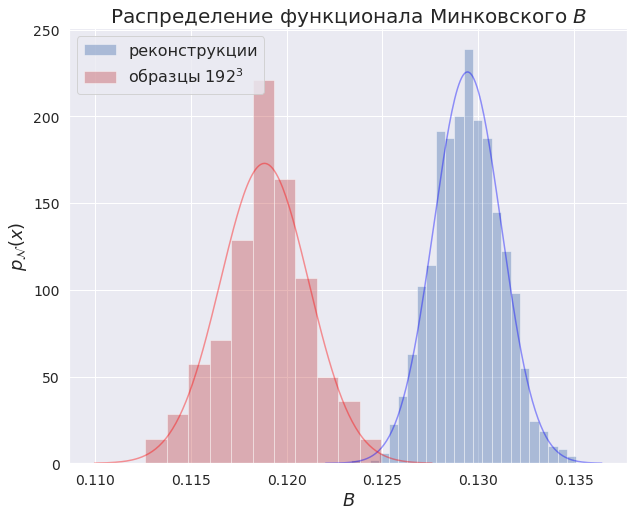

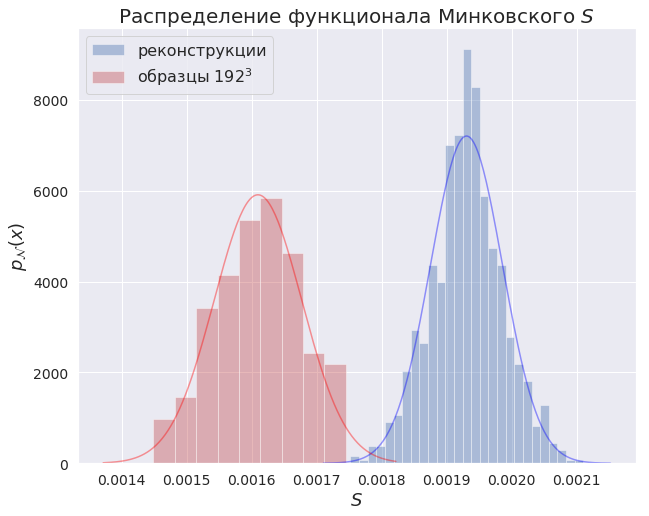

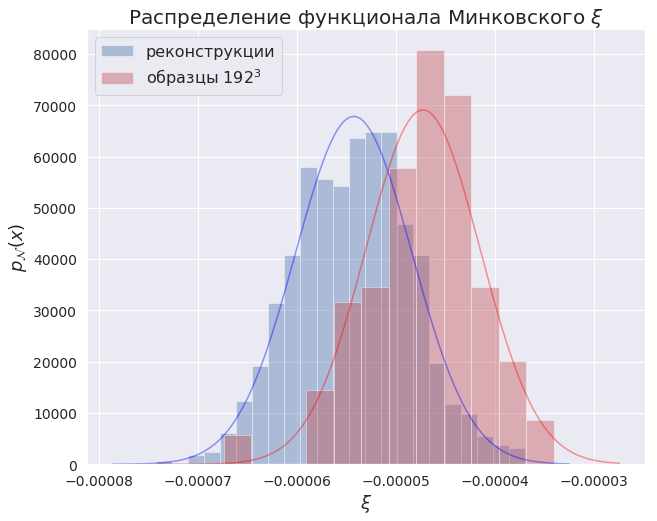

In [8]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / 'original-berea'))

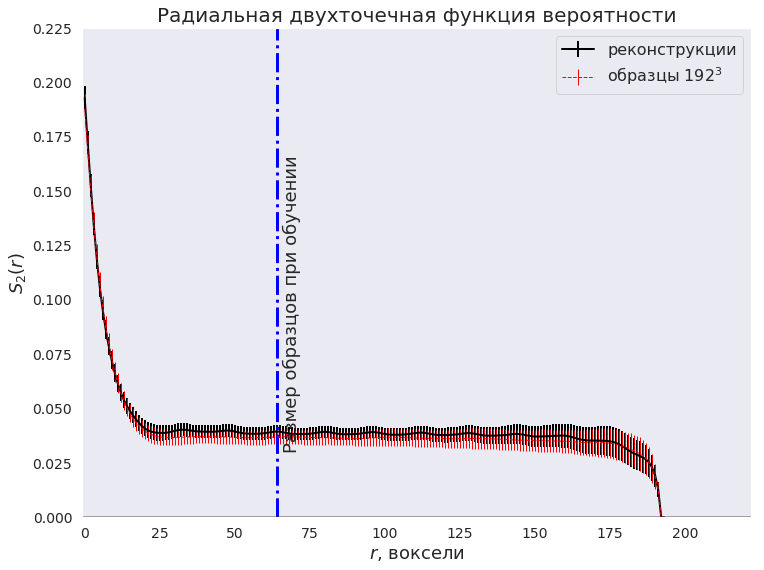

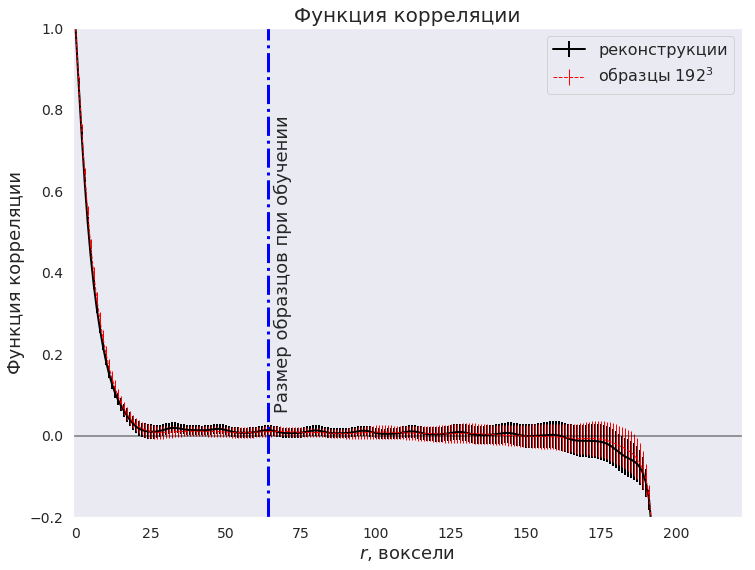

In [19]:
plot_correlation_pph(exp_dir=(EXP_DIR / 'original-berea'), dataset_dir=DATA_DIR)